In [5]:
import pandas as pd
import torch
import numpy as np

# Load the dataset
data_path="../data/"
df = pd.read_csv(f"{data_path}insurance.csv")

# Preprocess the data
t_sex = torch.tensor(pd.get_dummies(df["sex"]).values, dtype=torch.float32)
t_smoker = torch.tensor(pd.get_dummies(df["smoker"]).values, dtype=torch.float32)
t_region = torch.tensor(pd.get_dummies(df["region"]).values, dtype=torch.float32)

t_age = torch.tensor(df["age"].values, dtype=torch.float32).unsqueeze(1)/100
t_bmi = torch.tensor(df["bmi"].values, dtype=torch.float32).unsqueeze(1)/100
t_children = torch.tensor(df["children"].values, dtype=torch.float32).unsqueeze(1)/10
t_charges = torch.tensor(df["charges"].values, dtype=torch.float32).unsqueeze(1)/50000

t_input = torch.cat([t_age, t_bmi, t_children, t_sex, t_smoker, t_region], dim=1)
# Define your neural network model sigmoid if answer between 1 and 0
def build_model():
    return torch.nn.Sequential(
        torch.nn.Linear(11, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 1)
    )


0 tensor(0.1083, grad_fn=<MseLossBackward0>)
1 tensor(0.0749, grad_fn=<MseLossBackward0>)
2 tensor(0.0545, grad_fn=<MseLossBackward0>)
3 tensor(0.0395, grad_fn=<MseLossBackward0>)
4 tensor(0.0288, grad_fn=<MseLossBackward0>)
5 tensor(0.0231, grad_fn=<MseLossBackward0>)
6 tensor(0.0212, grad_fn=<MseLossBackward0>)
7 tensor(0.0212, grad_fn=<MseLossBackward0>)
8 tensor(0.0226, grad_fn=<MseLossBackward0>)
9 tensor(0.0247, grad_fn=<MseLossBackward0>)
10 tensor(0.0257, grad_fn=<MseLossBackward0>)
11 tensor(0.0255, grad_fn=<MseLossBackward0>)
12 tensor(0.0246, grad_fn=<MseLossBackward0>)
13 tensor(0.0232, grad_fn=<MseLossBackward0>)
14 tensor(0.0213, grad_fn=<MseLossBackward0>)
15 tensor(0.0197, grad_fn=<MseLossBackward0>)
16 tensor(0.0186, grad_fn=<MseLossBackward0>)
17 tensor(0.0177, grad_fn=<MseLossBackward0>)
18 tensor(0.0172, grad_fn=<MseLossBackward0>)
19 tensor(0.0171, grad_fn=<MseLossBackward0>)
20 tensor(0.0172, grad_fn=<MseLossBackward0>)
21 tensor(0.0173, grad_fn=<MseLossBackward0>

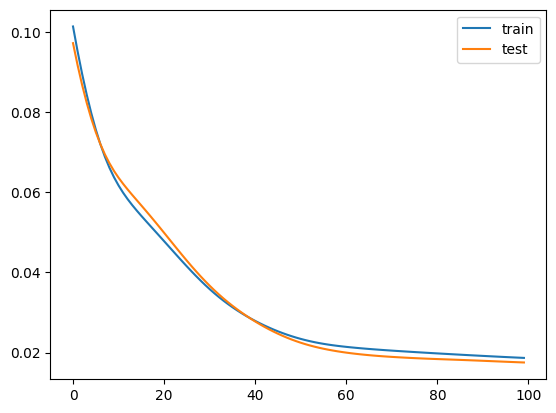

In [6]:

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(t_input):
    t_train_input = t_input[train_index]
    t_train_target = t_charges[train_index]
    t_test_input = t_input[test_index]
    t_test_target = t_charges[test_index]

    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(100):
        optimizer.zero_grad()
        t_train_output = model(t_train_input)
        loss = loss_fn(t_train_output, t_train_target)
        loss.backward()
        optimizer.step()
        print(epoch, loss)

    t_test_output = model(t_test_input)
    test_loss = loss_fn(t_test_output, t_test_target)
    print(f"Test loss: {test_loss}")

# separate 80/20 train and test
from sklearn.model_selection import train_test_split
t_train_input, t_test_input, t_train_target, t_test_target = train_test_split(t_input, t_charges, test_size=0.2, random_state=42)

model = build_model()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

losses = []
test_losses = []
for epoch in range(100):
    optimizer.zero_grad()
    t_train_output = model(t_train_input)
    loss = loss_fn(t_train_output, t_train_target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    t_test_output = model(t_test_input)
    test_loss = loss_fn(t_test_output, t_test_target)
    test_losses.append(test_loss.item())

import matplotlib.pyplot as plt
plt.plot(losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()


           actual    prediction
0     9095.068359   8914.209961
1     5272.175781   8091.861816
2    29330.984375  31165.039062
3     9301.893555   9978.388672
4    33750.292969  29164.292969
..            ...           ...
263  47055.531250  35839.769531
264  12222.898438   9437.555664
265   6067.126953   8254.604492
266  63770.429688  33553.992188
267   9872.701172  10127.019531

[268 rows x 2 columns]
           actual    prediction          diff
0     9095.068359   8914.209961   -180.858398
1     5272.175781   8091.861816   2819.686035
2    29330.984375  31165.039062   1834.054688
3     9301.893555   9978.388672    676.495117
4    33750.292969  29164.292969  -4586.000000
..            ...           ...           ...
263  47055.531250  35839.769531 -11215.761719
264  12222.898438   9437.555664  -2785.342773
265   6067.126953   8254.604492   2187.477539
266  63770.429688  33553.992188 -30216.437500
267   9872.701172  10127.019531    254.318359

[268 rows x 3 columns]
43836924.0
6620.

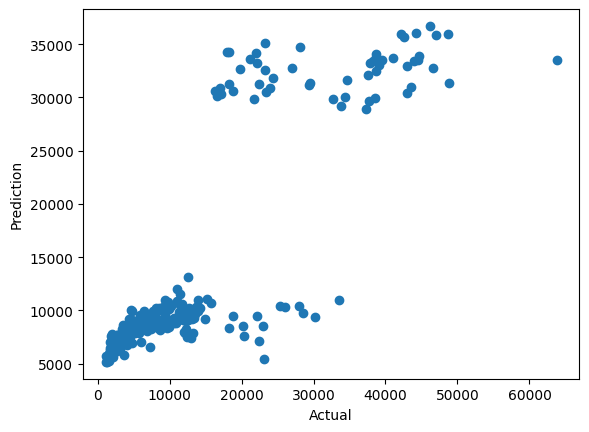

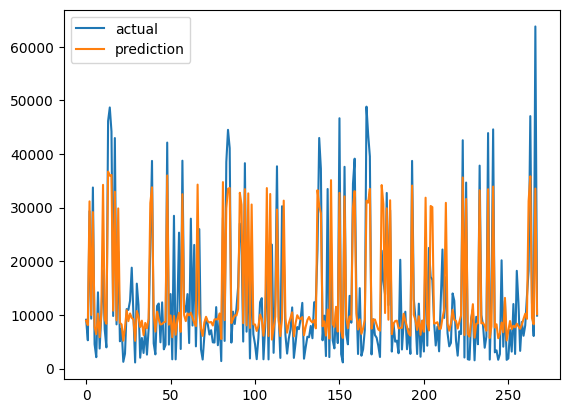

In [7]:

t_pred = model(t_test_input).detach() * 50000
t_test_target = t_test_target * 50000

df_pred = pd.DataFrame(torch.cat([t_test_target, t_pred], dim=1).numpy(), columns=["actual", "prediction"])
print(df_pred)

df_pred['diff'] = df_pred['prediction'] - df_pred['actual']
print(df_pred)

#compute mean squared error
print(df_pred['diff'].pow(2).mean())
#root mean squared error
print(np.sqrt(df_pred['diff'].pow(2).mean()))

#plot prediction vs actual
plt.scatter(t_test_target, t_pred)
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.show()

plt.plot(t_test_target, label="actual")
plt.plot(t_pred, label="prediction")
plt.legend()
plt.show()

Train data shape: torch.Size([1070, 11]), Train targets: torch.Size([1070, 1])
Test  data shape: torch.Size([268, 11]),  Test targets:  torch.Size([268, 1])
Epoch [50/200]  Train MSE: 0.028933, Test MSE: 0.029639
Epoch [100/200]  Train MSE: 0.018191, Test MSE: 0.017419
Epoch [150/200]  Train MSE: 0.015906, Test MSE: 0.015351
Epoch [200/200]  Train MSE: 0.014875, Test MSE: 0.014576


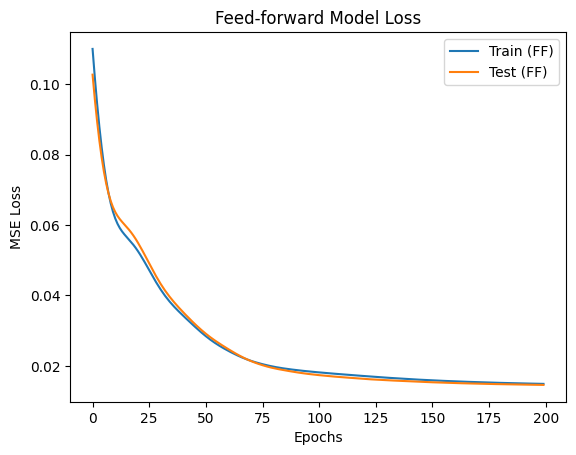

[Flow] Epoch [50/200]  Train NLL: -0.683476, Test NLL: -0.699199
[Flow] Epoch [100/200]  Train NLL: -0.834250, Test NLL: -0.783681
[Flow] Epoch [150/200]  Train NLL: -0.862061, Test NLL: -0.783188
[Flow] Epoch [200/200]  Train NLL: -0.891916, Test NLL: -0.795063


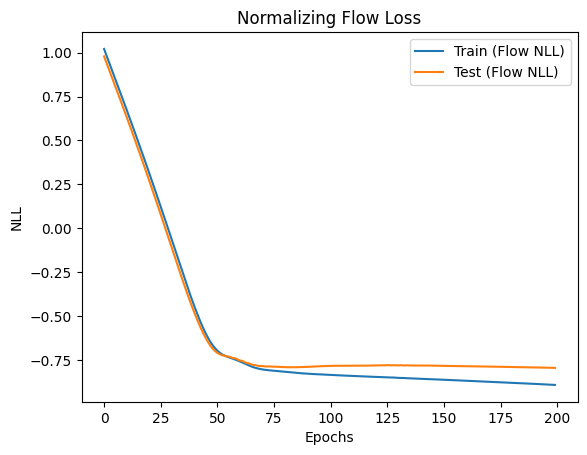

Feed-forward final MSE: 36439896.0
Feed-forward final RMSE: 6036.546875
Flow (mean prediction) MSE : 279656320.0
Flow (mean prediction) RMSE: 16722.927734375
         actual       ff_pred  flow_mean_pred      diff_ff     diff_flow
0   9095.068359  10827.834961    11052.780273  1732.766602   1957.711914
1   5272.175781   7406.358398     6248.748535  2134.182617    976.572754
2  29330.984375  32977.082031    34914.023438  3646.097656   5583.039062
3   9301.893555  10494.816406    10049.210938  1192.922852    747.317383
4  33750.292969  27886.519531    23097.550781 -5863.773438 -10652.742188
5   4536.258789   7218.121094     5885.627441  2681.862305   1349.368652
6   2117.338867   2890.732422     2230.288086   773.393555    112.949219
7  14210.535156  14134.289062    15090.457031   -76.246094    879.921875
8   3732.625000   4784.163574     4728.993164  1051.538574    996.368164
9  10264.442383  11546.793945    12352.180664  1282.351562   2087.738281


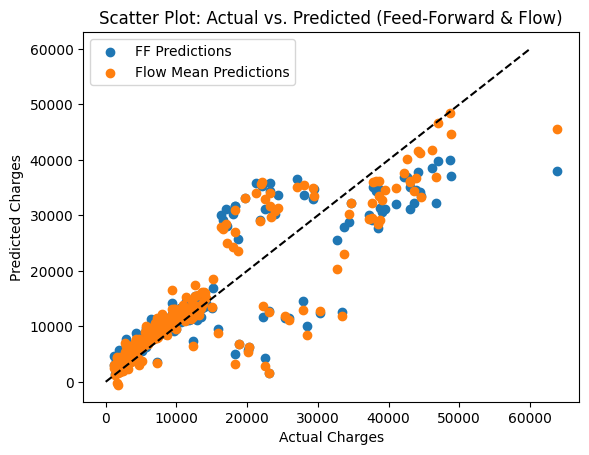


======== FINAL COMPARISON ========
Feed-Forward MSE  : 36439896.00
Feed-Forward RMSE : 6036.55
Flow (Mean)  MSE  : 279656320.00
Flow (Mean)  RMSE : 16722.93
Flow Final Test NLL (scaled data): -0.7951


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

################################################################################
# 1) Load and Preprocess the Data
################################################################################

# Read the CSV
df = pd.read_csv(f"{data_path}insurance.csv")

# Convert categorical columns to one-hot
t_sex = torch.tensor(pd.get_dummies(df["sex"]).values, dtype=torch.float32)
t_smoker = torch.tensor(pd.get_dummies(df["smoker"]).values, dtype=torch.float32)
t_region = torch.tensor(pd.get_dummies(df["region"]).values, dtype=torch.float32)

# Numeric columns (scaled)
t_age = torch.tensor(df["age"].values, dtype=torch.float32).unsqueeze(1) / 100.0
t_bmi = torch.tensor(df["bmi"].values, dtype=torch.float32).unsqueeze(1) / 100.0
t_children = torch.tensor(df["children"].values, dtype=torch.float32).unsqueeze(1) / 10.0

# Charges is our target (scaled)
t_charges = torch.tensor(df["charges"].values, dtype=torch.float32).unsqueeze(1) / 50000.0

# Combine input features into a single tensor of shape [N, 11]
t_input = torch.cat([
    t_age, t_bmi, t_children,
    t_sex,      # shape [N, 2]
    t_smoker,   # shape [N, 2]
    t_region    # shape [N, 4]
], dim=1)  # total columns = 3 + 2 + 2 + 4 = 11

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    t_input, t_charges, test_size=0.2, random_state=42
)

# Shapes
print(f"Train data shape: {X_train.shape}, Train targets: {y_train.shape}")
print(f"Test  data shape: {X_test.shape},  Test targets:  {y_test.shape}")

################################################################################
# 2) Feed-Forward Regression Model
################################################################################

class FeedForwardModel(nn.Module):
    def __init__(self, in_features=11, hidden=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

# Instantiate and train
ff_model = FeedForwardModel(in_features=11, hidden=50)
optimizer_ff = optim.Adam(ff_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Simple training loop
epochs = 200
losses_ff = []
val_losses_ff = []

for epoch in range(epochs):
    ff_model.train()
    optimizer_ff.zero_grad()
    y_pred = ff_model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer_ff.step()
    losses_ff.append(loss.item())

    # Evaluate test set
    ff_model.eval()
    with torch.no_grad():
        y_val_pred = ff_model(X_test)
        val_loss = loss_fn(y_val_pred, y_test)
        val_losses_ff.append(val_loss.item())

    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}]  Train MSE: {loss.item():.6f}, Test MSE: {val_loss.item():.6f}")

# Plot training vs. test loss
plt.plot(losses_ff, label="Train (FF)")
plt.plot(val_losses_ff, label="Test (FF)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Feed-forward Model Loss")
plt.show()

################################################################################
# 3) Normalizing Flow (RealNVP) for p(charges|x)
################################################################################
# We'll adapt a simplified RealNVP for 1D target y, conditioned on x.
################################################################################

# a) Coupling Layer
class ConditionalCouplingLayer(nn.Module):
    """
    RealNVP-style layer for 1D y with conditioning on x.
    We learn scale s(x) and translation t(x).
    """
    def __init__(self, x_dim, hidden_dim):
        super().__init__()
        self.net_scale = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.net_trans = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, y, x):
        """
        forward transform: z = (y - t(x)) * exp(-s(x))
        returns z, log_det
        """
        s = self.net_scale(x)
        t = self.net_trans(x)
        z = (y - t) * torch.exp(-s)
        log_det = -s.squeeze(-1)  # shape [batch], negative sign from forward transform
        return z, log_det

    def inverse(self, z, x):
        """
        inverse transform: y = z * exp(s(x)) + t(x)
        """
        s = self.net_scale(x)
        t = self.net_trans(x)
        y = z * torch.exp(s) + t
        return y


# b) RealNVP wrapper
class RealNVP(nn.Module):
    def __init__(self, x_dim, hidden_dim=64, num_flows=2):
        super().__init__()
        self.prior = torch.distributions.Normal(0, 1)
        self.layers = nn.ModuleList([
            ConditionalCouplingLayer(x_dim, hidden_dim) for _ in range(num_flows)
        ])

    def forward(self, y, x):
        """
        y -> z through all coupling layers, accumulate log_det
        returns z, log_det
        """
        log_det_sum = 0
        z = y
        for layer in self.layers:
            z, log_det = layer.forward(z, x)
            log_det_sum += log_det
        return z, log_det_sum

    def inverse(self, z, x):
        """
        z -> y
        """
        y = z
        for layer in reversed(self.layers):
            y = layer.inverse(y, x)
        return y

    def log_prob(self, y, x):
        """
        log p(y|x) = log p(z) + log|det(dz/dy)|
        where z = f(y;x)
        """
        z, log_det = self.forward(y, x)
        log_p_z = self.prior.log_prob(z)
        # log_p_z shape [batch], log_det shape [batch]
        return log_p_z + log_det

# c) Flow model training
flow_model = RealNVP(x_dim=11, hidden_dim=64, num_flows=2)  # tune as needed
optimizer_flow = optim.Adam(flow_model.parameters(), lr=0.001)

train_losses_flow = []
test_losses_flow = []
n_epochs = 200

for epoch in range(n_epochs):
    flow_model.train()
    optimizer_flow.zero_grad()
    # log_prob on train data
    log_p = flow_model.log_prob(y_train, X_train)  # shape [batch_size]
    loss_flow = -log_p.mean()  # negative log-likelihood
    loss_flow.backward()
    optimizer_flow.step()
    train_losses_flow.append(loss_flow.item())

    # Evaluate test
    flow_model.eval()
    with torch.no_grad():
        log_p_test = flow_model.log_prob(y_test, X_test)
        val_loss_flow = -log_p_test.mean()
        test_losses_flow.append(val_loss_flow.item())

    if (epoch+1) % 50 == 0:
        print(f"[Flow] Epoch [{epoch+1}/{n_epochs}]  Train NLL: {loss_flow.item():.6f}, Test NLL: {val_loss_flow.item():.6f}")

# Plot training vs test negative log-likelihood
plt.plot(train_losses_flow, label="Train (Flow NLL)")
plt.plot(test_losses_flow, label="Test (Flow NLL)")
plt.xlabel("Epochs")
plt.ylabel("NLL")
plt.legend()
plt.title("Normalizing Flow Loss")
plt.show()

################################################################################
# 4) Compare Point-Prediction MSE (Feed-Forward vs. Flow)
################################################################################

# We'll compare feed-forward's predictions to the flow's predicted mean.

# (a) Feed-forward final predictions (un-scale)
with torch.no_grad():
    ff_model.eval()
    y_ff_test_pred = ff_model(X_test)
# Remember the scale was /50000, so multiply back
y_ff_test_pred_unscaled = y_ff_test_pred * 50000.0
y_test_unscaled = y_test * 50000.0

mse_ff = torch.mean((y_ff_test_pred_unscaled - y_test_unscaled)**2)
rmse_ff = torch.sqrt(mse_ff)

print("Feed-forward final MSE:", mse_ff.item())
print("Feed-forward final RMSE:", rmse_ff.item())

# (b) Flow model: let's sample from the flow, compute the mean, compare MSE
flow_model.eval()
num_samples = 100  # how many samples from the base distribution to estimate mean

y_flow_preds = []
for i in range(X_test.shape[0]):
    x_i = X_test[i].unsqueeze(0)  # shape [1, 11]
    # Sample z from Normal(0,1)
    z = torch.randn(num_samples, 1)  # shape [100, 1]
    # Repeat x_i for each z sample
    x_rep = x_i.repeat(num_samples, 1)
    with torch.no_grad():
        # Map z -> y
        y_samples = flow_model.inverse(z.squeeze(-1), x_rep)
    # Take the mean of these samples
    mean_pred = y_samples.mean().item()
    y_flow_preds.append(mean_pred)

# Convert to a tensor
y_flow_preds = torch.tensor(y_flow_preds, dtype=torch.float32)
# Un-scale
y_flow_preds_unscaled = y_flow_preds * 50000.0

# Compute MSE, RMSE for the flow's mean predictions
mse_flow = torch.mean((y_flow_preds_unscaled - y_test_unscaled)**2)
rmse_flow = torch.sqrt(mse_flow)

print("Flow (mean prediction) MSE :", mse_flow.item())
print("Flow (mean prediction) RMSE:", rmse_flow.item())

################################################################################
# 5) Inspect Some Predictions
################################################################################

# Let's build a small DataFrame with actual vs. feed-forward vs. flow
df_compare = pd.DataFrame({
    "actual": y_test_unscaled.squeeze().numpy(),
    "ff_pred": y_ff_test_pred_unscaled.squeeze().numpy(),
    "flow_mean_pred": y_flow_preds_unscaled.squeeze().numpy()
})
df_compare["diff_ff"] = df_compare["ff_pred"] - df_compare["actual"]
df_compare["diff_flow"] = df_compare["flow_mean_pred"] - df_compare["actual"]

print(df_compare.head(10))

# We'll also do a quick scatter for feed-forward vs. actual
plt.scatter(df_compare["actual"], df_compare["ff_pred"], label="FF Predictions")
plt.scatter(df_compare["actual"], df_compare["flow_mean_pred"], label="Flow Mean Predictions")
plt.plot([0, 60000], [0, 60000], 'k--')  # diagonal line for reference
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.legend()
plt.title("Scatter Plot: Actual vs. Predicted (Feed-Forward & Flow)")
plt.show()

################################################################################
# 6) Summarize
################################################################################
print("\n======== FINAL COMPARISON ========")
print(f"Feed-Forward MSE  : {mse_ff.item():.2f}")
print(f"Feed-Forward RMSE : {rmse_ff.item():.2f}")
print(f"Flow (Mean)  MSE  : {mse_flow.item():.2f}")
print(f"Flow (Mean)  RMSE : {rmse_flow.item():.2f}")

# You might also look at flow_model's final test NLL:
final_flow_nll = test_losses_flow[-1]
print(f"Flow Final Test NLL (scaled data): {final_flow_nll:.4f}")



--- Fold 1 ---
Feed-Forward Test MSE: 31541296.00
Flow Test NLL: -0.7782
Flow Mean Prediction Test MSE: 36372664.00

--- Fold 2 ---
Feed-Forward Test MSE: 34047112.00
Flow Test NLL: -0.7973
Flow Mean Prediction Test MSE: 27979532.00

--- Fold 3 ---
Feed-Forward Test MSE: 30260454.00
Flow Test NLL: -0.7985
Flow Mean Prediction Test MSE: 30757722.00

--- Fold 4 ---
Feed-Forward Test MSE: 39826576.00
Flow Test NLL: -0.6941
Flow Mean Prediction Test MSE: 29087992.00

--- Fold 5 ---
Feed-Forward Test MSE: 41316748.00
Flow Test NLL: -0.7857
Flow Mean Prediction Test MSE: 39465412.00

=== k-Fold Cross-Validation Results ===
Average Feed-Forward Test MSE: 35398437.20
Average Flow Mean Prediction Test MSE: 32732664.40
Average Flow Test NLL: -0.7708


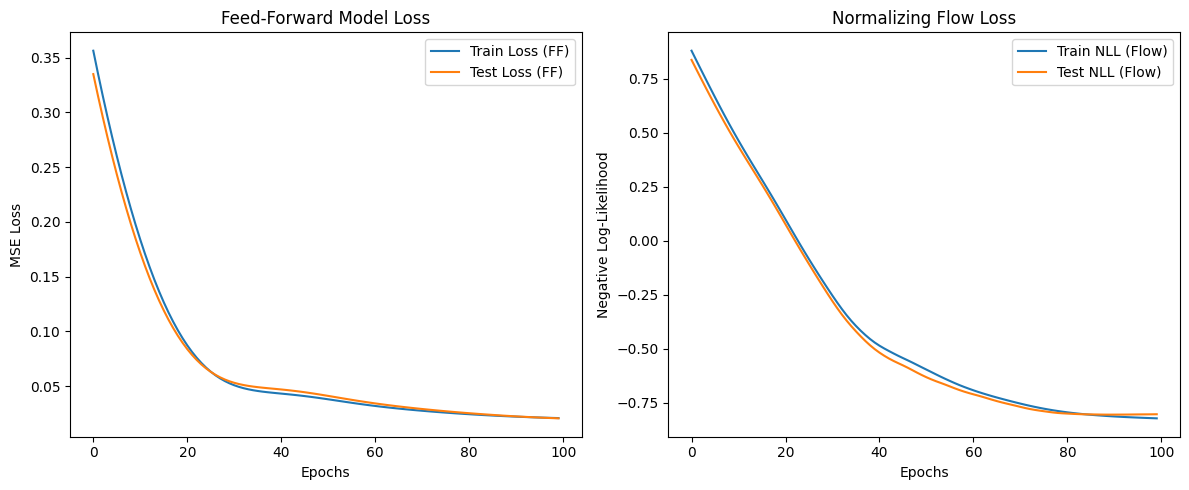

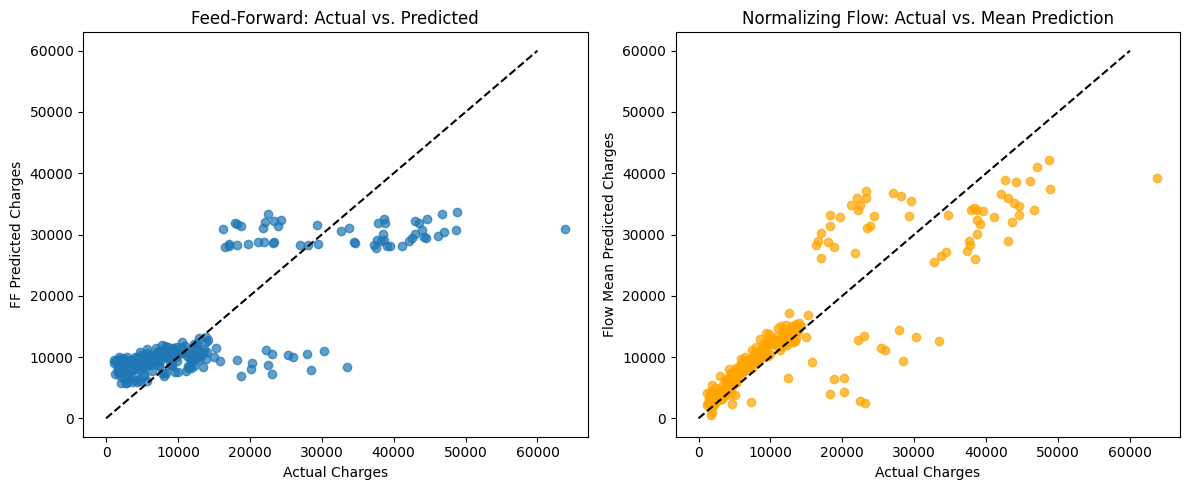

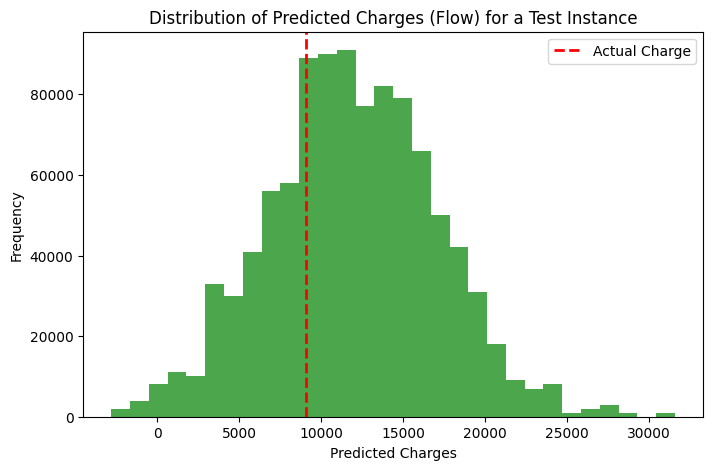

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

################################################################################
# 1) Data Loading and Preprocessing
################################################################################

# Load the dataset
df = pd.read_csv(f"{data_path}insurance.csv")


# One-hot encode categorical features
t_sex    = torch.tensor(pd.get_dummies(df["sex"]).values, dtype=torch.float32)
t_smoker = torch.tensor(pd.get_dummies(df["smoker"]).values, dtype=torch.float32)
t_region = torch.tensor(pd.get_dummies(df["region"]).values, dtype=torch.float32)

# Scale numeric features and target
t_age      = torch.tensor(df["age"].values, dtype=torch.float32).unsqueeze(1) / 100.0
t_bmi      = torch.tensor(df["bmi"].values, dtype=torch.float32).unsqueeze(1) / 100.0
t_children = torch.tensor(df["children"].values, dtype=torch.float32).unsqueeze(1) / 10.0
t_charges  = torch.tensor(df["charges"].values, dtype=torch.float32).unsqueeze(1) / 50000.0

# Concatenate all input features into one tensor (shape: [N, 11])
t_input = torch.cat([t_age, t_bmi, t_children, t_sex, t_smoker, t_region], dim=1)

#############################################
# 2) Define Models
#############################################

# 2a) Feed-Forward Regression Model (same as your first code)
def build_ff_model():
    return torch.nn.Sequential(
        torch.nn.Linear(11, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 1)
    )

# 2b) RealNVP Normalizing Flow Components
class ConditionalCouplingLayer(nn.Module):
    """
    A RealNVP coupling layer that transforms the 1D target y conditioned on x.
    It learns scale s(x) and translation t(x) functions.
    """
    def __init__(self, x_dim, hidden_dim):
        super().__init__()
        self.net_scale = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.net_trans = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, y, x):
        s = self.net_scale(x)
        t = self.net_trans(x)
        # Forward transformation: z = (y - t(x)) * exp(-s(x))
        z = (y - t) * torch.exp(-s)
        log_det = -s.squeeze(-1)  # log-determinant of Jacobian
        return z, log_det

    def inverse(self, z, x):
        s = self.net_scale(x)
        t = self.net_trans(x)
        # Inverse transformation: y = z * exp(s(x)) + t(x)
        y = z * torch.exp(s) + t
        return y

class RealNVP(nn.Module):
    def __init__(self, x_dim, hidden_dim=64, num_flows=2):
        super().__init__()
        self.prior = torch.distributions.Normal(0, 1)
        self.layers = nn.ModuleList([
            ConditionalCouplingLayer(x_dim, hidden_dim) for _ in range(num_flows)
        ])
    
    def forward(self, y, x):
        log_det_total = 0
        z = y
        for layer in self.layers:
            z, log_det = layer.forward(z, x)
            log_det_total += log_det
        return z, log_det_total
    
    def inverse(self, z, x):
        y = z
        for layer in reversed(self.layers):
            y = layer.inverse(y, x)
        return y
    
    def log_prob(self, y, x):
        z, log_det = self.forward(y, x)
        log_p_z = self.prior.log_prob(z)
        return log_p_z + log_det

#############################################
# 3) k-Fold Cross-Validation Evaluation
#############################################

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store average metrics for each fold
ff_fold_mse   = []  # Feed-forward test MSE
flow_fold_mse = []  # Flow (mean prediction) test MSE
flow_fold_nll = []  # Flow test negative log-likelihood

epochs_cv = 100
lr_cv     = 0.01
loss_fn   = nn.MSELoss()

fold_no = 1
for train_index, test_index in kf.split(t_input):
    print(f"\n--- Fold {fold_no} ---")
    # Prepare splits for this fold
    X_train_cv = t_input[train_index]
    y_train_cv = t_charges[train_index]
    X_test_cv  = t_input[test_index]
    y_test_cv  = t_charges[test_index]
    
    # Train Feed-Forward Model
    ff_model_cv = build_ff_model()
    optimizer_ff_cv = optim.Adam(ff_model_cv.parameters(), lr=lr_cv)
    for epoch in range(epochs_cv):
        ff_model_cv.train()
        optimizer_ff_cv.zero_grad()
        y_pred_cv = ff_model_cv(X_train_cv)
        loss_cv = loss_fn(y_pred_cv, y_train_cv)
        loss_cv.backward()
        optimizer_ff_cv.step()
    
    ff_model_cv.eval()
    with torch.no_grad():
        y_pred_test_cv = ff_model_cv(X_test_cv)
    # Un-scale predictions/targets
    y_pred_test_cv_unscaled = y_pred_test_cv * 50000.0
    y_test_cv_unscaled      = y_test_cv * 50000.0
    mse_ff_cv = torch.mean((y_pred_test_cv_unscaled - y_test_cv_unscaled)**2)
    ff_fold_mse.append(mse_ff_cv.item())
    print(f"Feed-Forward Test MSE: {mse_ff_cv.item():.2f}")
    
    # Train Normalizing Flow Model
    flow_model_cv = RealNVP(x_dim=11, hidden_dim=64, num_flows=2)
    optimizer_flow_cv = optim.Adam(flow_model_cv.parameters(), lr=lr_cv)
    for epoch in range(epochs_cv):
        flow_model_cv.train()
        optimizer_flow_cv.zero_grad()
        log_prob_cv = flow_model_cv.log_prob(y_train_cv, X_train_cv)
        loss_flow_cv = -log_prob_cv.mean()
        loss_flow_cv.backward()
        optimizer_flow_cv.step()
    
    flow_model_cv.eval()
    with torch.no_grad():
        log_prob_test_cv = flow_model_cv.log_prob(y_test_cv, X_test_cv)
    nll_flow_cv = -log_prob_test_cv.mean().item()
    flow_fold_nll.append(nll_flow_cv)
    print(f"Flow Test NLL: {nll_flow_cv:.4f}")
    
    # Estimate Flow Mean Predictions and compute MSE
    num_samples_cv = 100  # samples per test instance
    flow_preds_cv = []
    for i in range(X_test_cv.shape[0]):
        x_i_cv = X_test_cv[i].unsqueeze(0)  # [1, 11]
        z_samples_cv = torch.randn(num_samples_cv, 1)
        x_repeated_cv = x_i_cv.repeat(num_samples_cv, 1)
        with torch.no_grad():
            y_samples_cv = flow_model_cv.inverse(z_samples_cv.squeeze(-1), x_repeated_cv)
        flow_preds_cv.append(y_samples_cv.mean().item())
    flow_preds_cv = torch.tensor(flow_preds_cv, dtype=torch.float32)
    flow_preds_cv_unscaled = flow_preds_cv * 50000.0
    mse_flow_cv = torch.mean((flow_preds_cv_unscaled - y_test_cv_unscaled.squeeze())**2)
    flow_fold_mse.append(mse_flow_cv.item())
    print(f"Flow Mean Prediction Test MSE: {mse_flow_cv.item():.2f}")
    
    fold_no += 1

print("\n=== k-Fold Cross-Validation Results ===")
print(f"Average Feed-Forward Test MSE: {np.mean(ff_fold_mse):.2f}")
print(f"Average Flow Mean Prediction Test MSE: {np.mean(flow_fold_mse):.2f}")
print(f"Average Flow Test NLL: {np.mean(flow_fold_nll):.4f}")

#############################################
# 4) Train/Test Split Experiment for Detailed Visualizations
#############################################

# Use a separate 80/20 split for visualization purposes
X_train, X_test, y_train, y_test = train_test_split(t_input, t_charges, test_size=0.2, random_state=42)

# ----- Feed-Forward Model -----
ff_model = build_ff_model()
optimizer_ff = optim.Adam(ff_model.parameters(), lr=0.001)
epochs = 100
losses_ff = []
val_losses_ff = []

for epoch in range(epochs):
    ff_model.train()
    optimizer_ff.zero_grad()
    y_pred = ff_model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer_ff.step()
    losses_ff.append(loss.item())
    
    ff_model.eval()
    with torch.no_grad():
        y_val_pred = ff_model(X_test)
        val_loss = loss_fn(y_val_pred, y_test)
        val_losses_ff.append(val_loss.item())

# ----- Normalizing Flow Model -----
flow_model = RealNVP(x_dim=11, hidden_dim=64, num_flows=2)
optimizer_flow = optim.Adam(flow_model.parameters(), lr=0.001)
losses_flow = []
val_losses_flow = []

for epoch in range(epochs):
    flow_model.train()
    optimizer_flow.zero_grad()
    log_prob = flow_model.log_prob(y_train, X_train)
    loss_flow = -log_prob.mean()
    loss_flow.backward()
    optimizer_flow.step()
    losses_flow.append(loss_flow.item())
    
    flow_model.eval()
    with torch.no_grad():
        log_prob_val = flow_model.log_prob(y_test, X_test)
        val_loss_flow = -log_prob_val.mean()
        val_losses_flow.append(val_loss_flow.item())

#############################################
# 5) Visualizations
#############################################

# 5a. Plot training and test loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses_ff, label="Train Loss (FF)")
plt.plot(val_losses_ff, label="Test Loss (FF)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Feed-Forward Model Loss")

plt.subplot(1,2,2)
plt.plot(losses_flow, label="Train NLL (Flow)")
plt.plot(val_losses_flow, label="Test NLL (Flow)")
plt.xlabel("Epochs")
plt.ylabel("Negative Log-Likelihood")
plt.legend()
plt.title("Normalizing Flow Loss")
plt.tight_layout()
plt.show()

# 5b. Scatter plots: Actual vs. Predicted for both models
with torch.no_grad():
    ff_model.eval()
    y_ff_pred = ff_model(X_test)
    # Un-scale predictions and targets
    y_ff_pred_unscaled = y_ff_pred * 50000.0
    y_test_unscaled = y_test * 50000.0

    # Flow model: estimate mean predictions from samples
    num_samples = 100
    flow_preds = []
    for i in range(X_test.shape[0]):
        x_i = X_test[i].unsqueeze(0)
        z_samples = torch.randn(num_samples, 1)
        x_repeated = x_i.repeat(num_samples, 1)
        y_samples = flow_model.inverse(z_samples.squeeze(-1), x_repeated)
        flow_preds.append(y_samples.mean().item())
    flow_preds = torch.tensor(flow_preds, dtype=torch.float32)
    flow_preds_unscaled = flow_preds * 50000.0

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test_unscaled.numpy(), y_ff_pred_unscaled.numpy(), alpha=0.7)
plt.plot([0, 60000], [0, 60000], 'k--')
plt.xlabel("Actual Charges")
plt.ylabel("FF Predicted Charges")
plt.title("Feed-Forward: Actual vs. Predicted")

plt.subplot(1,2,2)
plt.scatter(y_test_unscaled.numpy(), flow_preds_unscaled.numpy(), alpha=0.7, color='orange')
plt.plot([0, 60000], [0, 60000], 'k--')
plt.xlabel("Actual Charges")
plt.ylabel("Flow Mean Predicted Charges")
plt.title("Normalizing Flow: Actual vs. Mean Prediction")
plt.tight_layout()
plt.show()

# 5c. Plot distribution of predictions from the flow for a single test sample
# Choose an example from the test set (e.g., first instance)
with torch.no_grad():
    x_example = X_test[0].unsqueeze(0)
    actual_charge = (y_test[0] * 50000.0).item()
    num_dist_samples = 1000
    z_dist_samples = torch.randn(num_dist_samples, 1)
    x_example_repeated = x_example.repeat(num_dist_samples, 1)
    y_dist_samples = flow_model.inverse(z_dist_samples.squeeze(-1), x_example_repeated)
    # Flatten the output to ensure it's 1D
    y_dist_samples_unscaled = (y_dist_samples * 50000.0).squeeze().flatten().numpy()

plt.figure(figsize=(8,5))
plt.hist(y_dist_samples_unscaled, bins=30, alpha=0.7, color='green')
plt.axvline(actual_charge, color='red', linestyle='dashed', linewidth=2, label="Actual Charge")
plt.xlabel("Predicted Charges")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Charges (Flow) for a Test Instance")
plt.legend()
plt.show()




100%|██████████| 268/268 [14:07<00:00,  3.16s/it]


Average CRPS: 6122.827955785178


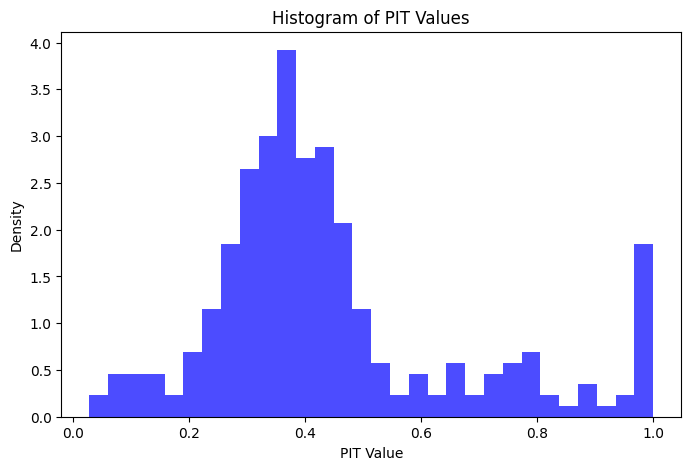

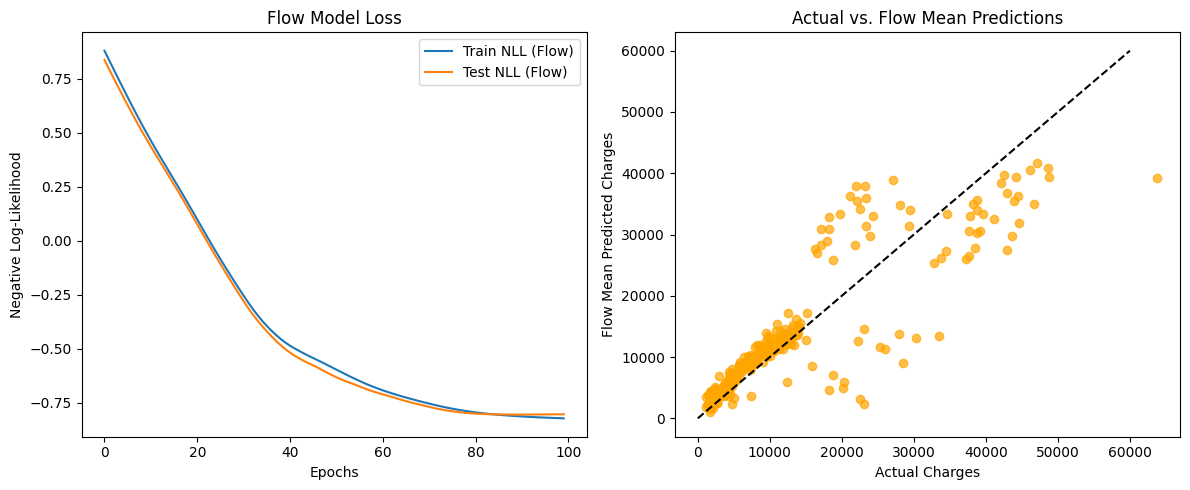

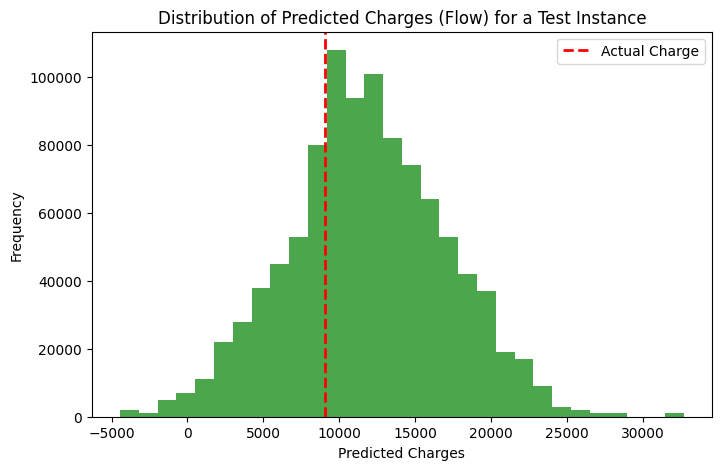

In [21]:
from tqdm import tqdm

#############################################
# 4) Additional Distribution Metrics: PIT and CRPS
#############################################

def compute_distribution_metrics(flow_model, X_test, y_test, num_samples=1000):
    """
    Compute the PIT values and CRPS for each test sample.
    - PIT: the fraction of predicted samples below the actual target.
    - CRPS: computed as mean(|samples - y_true|) - 0.5 * mean(|samples_i - samples_j|).
    Returns two lists: one for PIT values and one for CRPS values.
    """
    pit_values = []
    crps_values = []
    for i in tqdm(range(X_test.shape[0])):
        x_i = X_test[i].unsqueeze(0)  # [1, features]
        # Sample from the predictive distribution
        z_samples = torch.randn(num_samples, 1)
        x_repeated = x_i.repeat(num_samples, 1)
        with torch.no_grad():
            y_samples = flow_model.inverse(z_samples.squeeze(-1), x_repeated)
        # Un-scale predictions
        y_samples_unscaled = (y_samples * 50000.0).squeeze()
        # Get true value (un-scaled)
        y_true = (y_test[i] * 50000.0).item()
        
        # Compute PIT: fraction of samples below the true value
        pit = (y_samples_unscaled < y_true).float().mean().item()
        pit_values.append(pit)
        
        # Compute CRPS:
        # CRPS = mean(|y_samples - y_true|) - 0.5 * mean(|y_samples_i - y_samples_j|)
        abs_errors = torch.abs(y_samples_unscaled - y_true)
        term1 = abs_errors.mean().item()
        # Compute pairwise absolute differences in a vectorized way
        diff = torch.abs(y_samples_unscaled.unsqueeze(0) - y_samples_unscaled.unsqueeze(1))
        term2 = 0.5 * diff.mean().item()
        crps = term1 - term2
        crps_values.append(crps)
    return pit_values, crps_values

pit_vals, crps_vals = compute_distribution_metrics(flow_model, X_test, y_test, num_samples=1000)
avg_crps = np.mean(crps_vals)
print("Average CRPS:", avg_crps)

# Plot PIT histogram
plt.figure(figsize=(8,5))
plt.hist(pit_vals, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel("PIT Value")
plt.ylabel("Density")
plt.title("Histogram of PIT Values")
plt.show()

#############################################
# 5) Other Visualizations (Loss Curves and Scatter Plots)
#############################################

# Loss curves for the flow model
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses_flow, label="Train NLL (Flow)")
plt.plot(val_losses_flow, label="Test NLL (Flow)")
plt.xlabel("Epochs")
plt.ylabel("Negative Log-Likelihood")
plt.legend()
plt.title("Flow Model Loss")

# For scatter plots, let's obtain the mean predictions from the flow
num_samples = 100
flow_mean_preds = []
for i in range(X_test.shape[0]):
    x_i = X_test[i].unsqueeze(0)
    z_samples = torch.randn(num_samples, 1)
    x_repeated = x_i.repeat(num_samples, 1)
    with torch.no_grad():
        y_samples = flow_model.inverse(z_samples.squeeze(-1), x_repeated)
    flow_mean_preds.append(y_samples.mean().item())
flow_mean_preds = torch.tensor(flow_mean_preds, dtype=torch.float32)
flow_mean_preds_unscaled = flow_mean_preds * 50000.0
y_test_unscaled = y_test * 50000.0

plt.subplot(1,2,2)
plt.scatter(y_test_unscaled.numpy(), flow_mean_preds_unscaled.numpy(), alpha=0.7, color='orange')
plt.plot([0, 60000], [0, 60000], 'k--')
plt.xlabel("Actual Charges")
plt.ylabel("Flow Mean Predicted Charges")
plt.title("Actual vs. Flow Mean Predictions")
plt.tight_layout()
plt.show()

#############################################
# 6) Distribution Plot for a Single Test Instance
#############################################

with torch.no_grad():
    x_example = X_test[0].unsqueeze(0)
    actual_charge = (y_test[0] * 50000.0).item()
    z_dist_samples = torch.randn(1000, 1)
    x_example_repeated = x_example.repeat(1000, 1)
    y_dist_samples = flow_model.inverse(z_dist_samples.squeeze(-1), x_example_repeated)
    # Squeeze to ensure a 1D array
    y_dist_samples_unscaled = (y_dist_samples * 50000.0).squeeze().flatten().numpy()

plt.figure(figsize=(8,5))
plt.hist(y_dist_samples_unscaled, bins=30, alpha=0.7, color='green')
plt.axvline(actual_charge, color='red', linestyle='dashed', linewidth=2, label="Actual Charge")
plt.xlabel("Predicted Charges")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Charges (Flow) for a Test Instance")
plt.legend()
plt.show()
